In [2]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [3]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, lfilter
from scipy.signal import freqz

FS = 250

In [4]:
subjectData = {}

In [5]:
ns = 10

# data_path = os.path.join("A{:02d}T.npz".format(1))
for i in range(1,ns):
    data_path = os.path.join("A{:02d}T.npz".format(i))
    subject = 'subject{:02d}'.format(i)

    subjectData[subject] = np.load(data_path)

In [6]:
print(type(subjectData['subject01']))
print(subjectData['subject01'].files)

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


s: contains time-series recorded EEG signals of shape MxN array. N is the number of electrodes (22 EEG and 3 EOG), M can vary

etpye: event type to indicate event occurence

epos: event position denoting event start at s


edur: event duration artifacts: size of 288x1, 6x48 = 288 where 6 is the number of runs with 48 trials. 48 trials have 12 trials of 4 class each

In [7]:
print('Sample\t Electrodes')
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    # print(type(subjectData[sub]['s']))
    print('subject{:02d}'.format(i), subjectData[sub]['s'].shape)

Sample	 Electrodes
subject01 (672528, 25)
subject02 (677169, 25)
subject03 (660530, 25)
subject04 (600915, 25)
subject05 (686120, 25)
subject06 (678980, 25)
subject07 (681071, 25)
subject08 (675270, 25)
subject09 (673328, 25)


In [8]:
# Bandpass filter
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b,a,signal, axis=-1)
    return y

In [9]:
def butterFilter(cleanData, data, sub):
    lowcut = 4
    highcut = 40
    fs = 250
    print('Processing', sub)
    cleanData[sub] = butter_bandpass_filter(data, lowcut, highcut, fs)

In [10]:
def manyButterFilters(cleanData, data, sub):
    lowcut = 4
    highcut = 40
    fs = 250
    print('Processing', sub)
    cleanData[sub] = butter_bandpass_filter(data, lowcut, highcut, fs)

In [11]:
# Transpose the raw EEG data to apply filtering on the time-series axis
rawData = {}
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    rawData[sub] = subjectData[sub]['s'].T

    print('subject{:02d}'.format(i), rawData[sub].shape)

# rawData

subject01 (25, 672528)
subject02 (25, 677169)
subject03 (25, 660530)
subject04 (25, 600915)
subject05 (25, 686120)
subject06 (25, 678980)
subject07 (25, 681071)
subject08 (25, 675270)
subject09 (25, 673328)


In [12]:
cleanEEG = {}
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    butterFilter(cleanEEG, rawData[sub], sub)

    print(cleanEEG[sub].shape)

Processing subject01
(25, 672528)
Processing subject02
(25, 677169)
Processing subject03
(25, 660530)
Processing subject04
(25, 600915)
Processing subject05
(25, 686120)
Processing subject06
(25, 678980)
Processing subject07
(25, 681071)
Processing subject08
(25, 675270)
Processing subject09
(25, 673328)


There are 4 classes with event code as 769, 770, 771, 772 for left, right, foot and tongue.

In [13]:
left_class_code = 769
right_class_code = 770
foot_class_code = 771
tongue_class_code = 772

for i in range(1,2):
    sub = 'subject{:02d}'.format(i)
    right_dur = subjectData[sub]['epos'][subjectData[sub]['edur'] == right_class_code]
    left = subjectData[sub]['epos'][subjectData[sub]['etyp'] == left_class_code]
    right = subjectData[sub]['epos'][subjectData[sub]['etyp'] == right_class_code]
    foot = subjectData[sub]['epos'][subjectData[sub]['etyp'] == foot_class_code]
    tongue = subjectData[sub]['epos'][subjectData[sub]['etyp'] == tongue_class_code]



In [14]:
right

array([ 96290, 102361, 108259, 119941, 122061, 132307, 146352, 152424,
       156623, 172782, 176750, 182703, 195077, 205094, 218896, 233134,
       237118, 243187, 259656, 263648, 267536, 273585, 275704, 277610,
       286039, 303927, 311644, 317739, 328057, 335914, 338018, 344023,
       352384, 358511, 360483, 378487, 382874, 392866, 406535, 412566,
       424892, 426804, 432749, 434853, 436857, 461206, 471280, 475322,
       485582, 497597, 501398, 503370, 507281, 513475, 515511, 517577,
       519647, 531688, 535667, 560122, 580465, 594432, 602149, 604116,
       606236, 610310, 618562, 638706, 640798, 658935, 660925, 668992],
      dtype=int32)

These are the sample points where the event has started

Steps to start with

1. Remove EOG channels from all subjects

2. Crop the data for each subject such that you get the data during the motor imagery peroid (refer Experimental_Paradigm)


In [15]:
print(subjectData['subject01'].files)

# print(subjectData['subject01']['s'])
# print(subjectData['subject02']['etyp'])
# print(subjectData['subject02']['epos'])
# print(len(subjectData['subject02']['edur']))
# print((subjectData['subject02']['etyp']))


['s', 'etyp', 'epos', 'edur', 'artifacts']


In [16]:
def preprocess_subject_data(subject_data):
    eeg_data = subject_data['s'][:, :22]  # Keep only EEG channels, so first 22 channels
    eeg_data = butter_bandpass_filter(eeg_data, 4, 40, 250)  # Filtered signal; note: 250 = frequency signal
    return eeg_data

processed_data = preprocess_subject_data(subjectData['subject01'])

# print(processed_data.files)

print(processed_data)

[[-0.12413272 -0.97239483 -3.48768025 ...  4.38812515  3.51662096
   4.28496359]
 [-0.12871961 -1.00462194 -3.60365294 ...  2.95697117  2.62593275
   3.99382314]
 [-0.0917378  -0.73169314 -2.68264345 ...  1.10543494  1.41723633
   3.51528   ]
 ...
 [ 0.03239491  0.2791169   1.13517762 ...  1.4068474   0.14132073
  -1.84857238]
 [ 0.00860042  0.07579908  0.34366195 ...  1.19321182  1.23769793
  -0.45890977]
 [ 0.00802706  0.07452999  0.34174108 ... -0.57122735  0.15591882
  -1.14051005]]


(672528, 25)
(672528,)
(1000,)


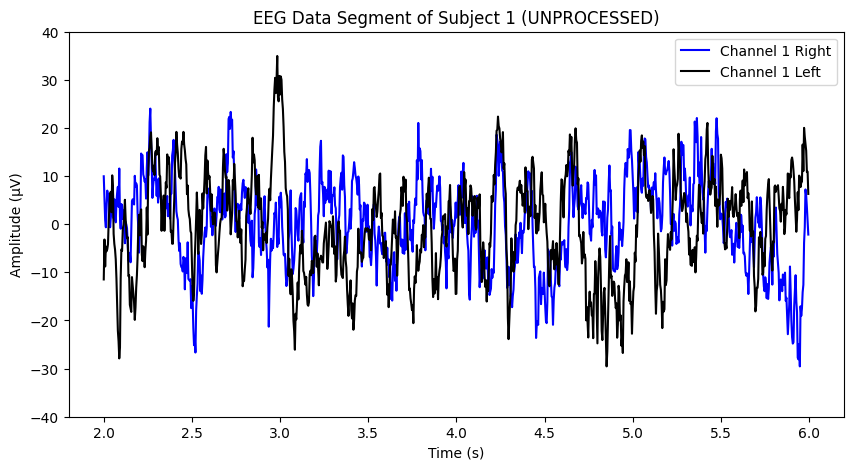

In [17]:
subject = f'subject{1:02d}'
# eeg_data = preprocess_subject_data(subjectData[subject])
start, end = right[0] + (2 * FS), right[0] + (6 * FS)
lstart, lend = left[0] + (2 * FS), left[0] + (6 * FS)

print(subjectData[subject]['s'].shape)
temp = subjectData[subject]['s'][:, 0] # only gets 0th channel from eeg_data

print(temp.shape)

segments_of_temp_right = temp[start:end]
segments_of_temp_left = temp[lstart:lend]
print(segments_of_temp_left.shape)
time_axis = np.arange(0, len(segments_of_temp_right)) / FS + 2

plt.figure(figsize=(10, 5))
plt.plot(time_axis, segments_of_temp_right[:], label = f"Channel {i} Right", color = "blue")
plt.plot(time_axis, segments_of_temp_left[:], label = f"Channel {i} Left", color = "black")

plt.ylim([-40,40])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title("EEG Data Segment of Subject 1 (UNPROCESSED)")
plt.legend()
plt.show()


(672528, 22)
(672528,)


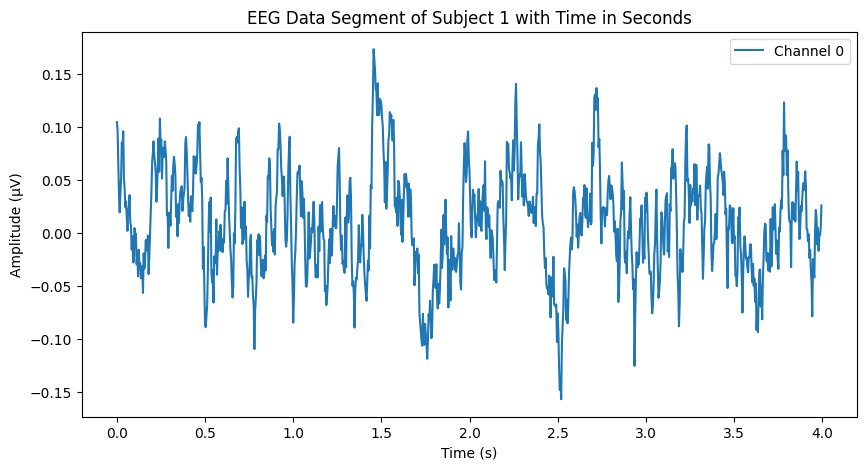

In [18]:
subject = f'subject{1:02d}'
eeg_data = preprocess_subject_data(subjectData[subject])
start, end = right[0], right[0] + (4 * FS)

print(eeg_data.shape)
temp = eeg_data[:, 0] # only gets 0th channel from eeg_data

print(temp.shape)

segments_of_temp2 = eeg_data[start:end, :]
time_axis = np.arange(0, len(segments_of_temp2)) / FS

plt.figure(figsize=(10, 5))
for i in range(1): # plot only first channel (0th channel) from eeg_data of subject1
    plt.plot(time_axis, segments_of_temp2[:,0], label = f"Channel {i}")

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title("EEG Data Segment of Subject 1 with Time in Seconds")
plt.legend()
plt.show()


In [19]:
# subject = f'subject{1:02d}'
# eeg_data = preprocess_subject_data(subjectData[subject])

# # Extract a segment of the first two channels (0 and 1) between the right-hand motor imagery events
# temp2 = eeg_data[:, 0]  # Select channels 0 and 1
# start, end = right[0], right[0] + (4 * FS)
# segment_of_temp2 = temp2[start:end, :]  # Get the segment for both channels

# # Create a time axis in seconds
# FS = 250  # Sampling rate in Hz
# time_axis = np.arange(0, len(segment_of_temp2)) / FS

# # Plot the two channels
# plt.figure(figsize=(10, 5))
# plt.plot(time_axis, segment_of_temp2[:, 0], label="Channel 0")  # Plot channel 0
# plt.plot(time_axis, segment_of_temp2[:, 1], label="Channel 1")  # Plot channel 1
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude (µV)')
# plt.title("EEG Data Segment for Two Channels")
# plt.legend()  # Show legend to identify channels
# plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

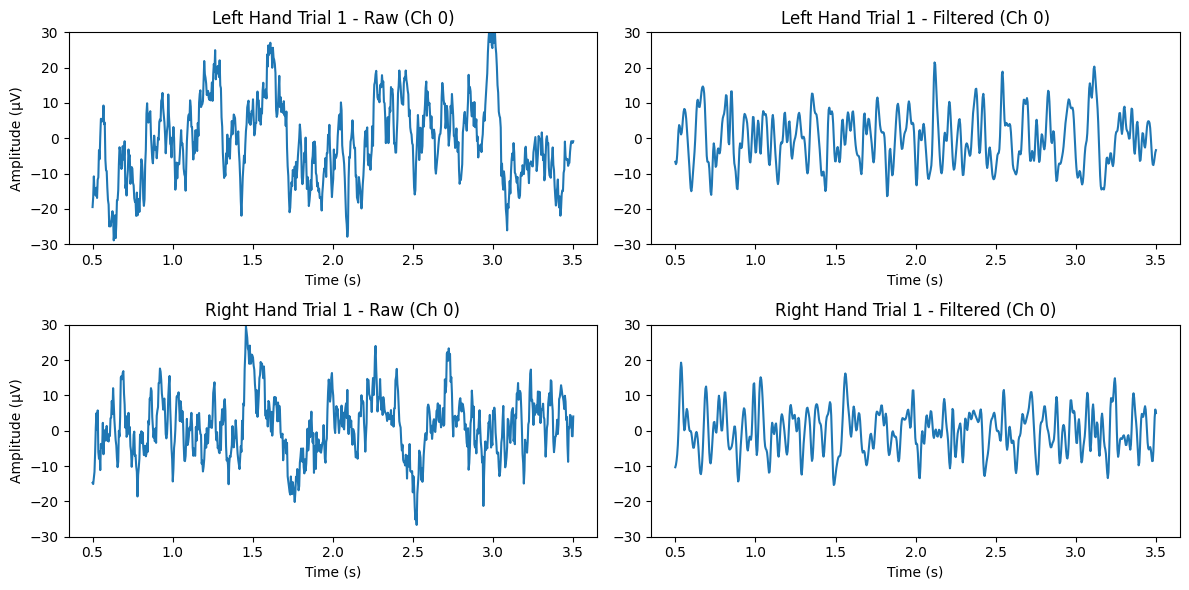

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
fs = 250  # Sampling frequency (Hz)
start_time = 0.5  # seconds
end_time = 3.5  # seconds
duration = end_time - start_time
samples = int(duration * fs)
time_axis = np.linspace(start_time, end_time, samples)

channel = 0  # EEG channel index
subject = 'subject01'

# Get trial positions
left_pos = subjectData[subject]['epos'][subjectData[subject]['etyp'] == 769][0]
right_pos = subjectData[subject]['epos'][subjectData[subject]['etyp'] == 770][0]

# Extract raw and filtered signals
raw_left = rawData[subject][channel, left_pos + int(start_time * fs): left_pos + int(end_time * fs)]
filt_left = cleanEEG[subject][channel, left_pos + int(start_time * fs): left_pos + int(end_time * fs)]
raw_right = rawData[subject][channel, right_pos + int(start_time * fs): right_pos + int(end_time * fs)]
filt_right = cleanEEG[subject][channel, right_pos + int(start_time * fs): right_pos + int(end_time * fs)]

# Plot with consistent y-axis limits
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(time_axis, raw_left)
plt.title('Left Hand Trial 1 - Raw (Ch 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.ylim([-30, 30])

plt.subplot(2, 2, 2)
plt.plot(time_axis, filt_left)
plt.title('Left Hand Trial 1 - Filtered (Ch 0)')
plt.xlabel('Time (s)')
plt.ylim([-30, 30])

plt.subplot(2, 2, 3)
plt.plot(time_axis, raw_right)
plt.title('Right Hand Trial 1 - Raw (Ch 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.ylim([-30, 30])

plt.subplot(2, 2, 4)
plt.plot(time_axis, filt_right)
plt.title('Right Hand Trial 1 - Filtered (Ch 0)')
plt.xlabel('Time (s)')
plt.ylim([-30, 30])

plt.tight_layout()
plt.show()


In [21]:
def create_band_filtered_data(data, fs=250, lowcut=4, highcut=40, interval=4):
    bands_data = {}
    band_ranges = np.arange(lowcut, highcut, interval)
    for start in band_ranges:
        band_label = f"{start:02d}_{start+interval:02d}"
        bands_data[band_label] = butter_bandpass_filter(data, start, start+interval, fs)
    return bands_data

# Apply to subject01 raw data (shape: channels x samples)
subject = 'subject01'
band_filtered_subject01 = create_band_filtered_data(rawData[subject])

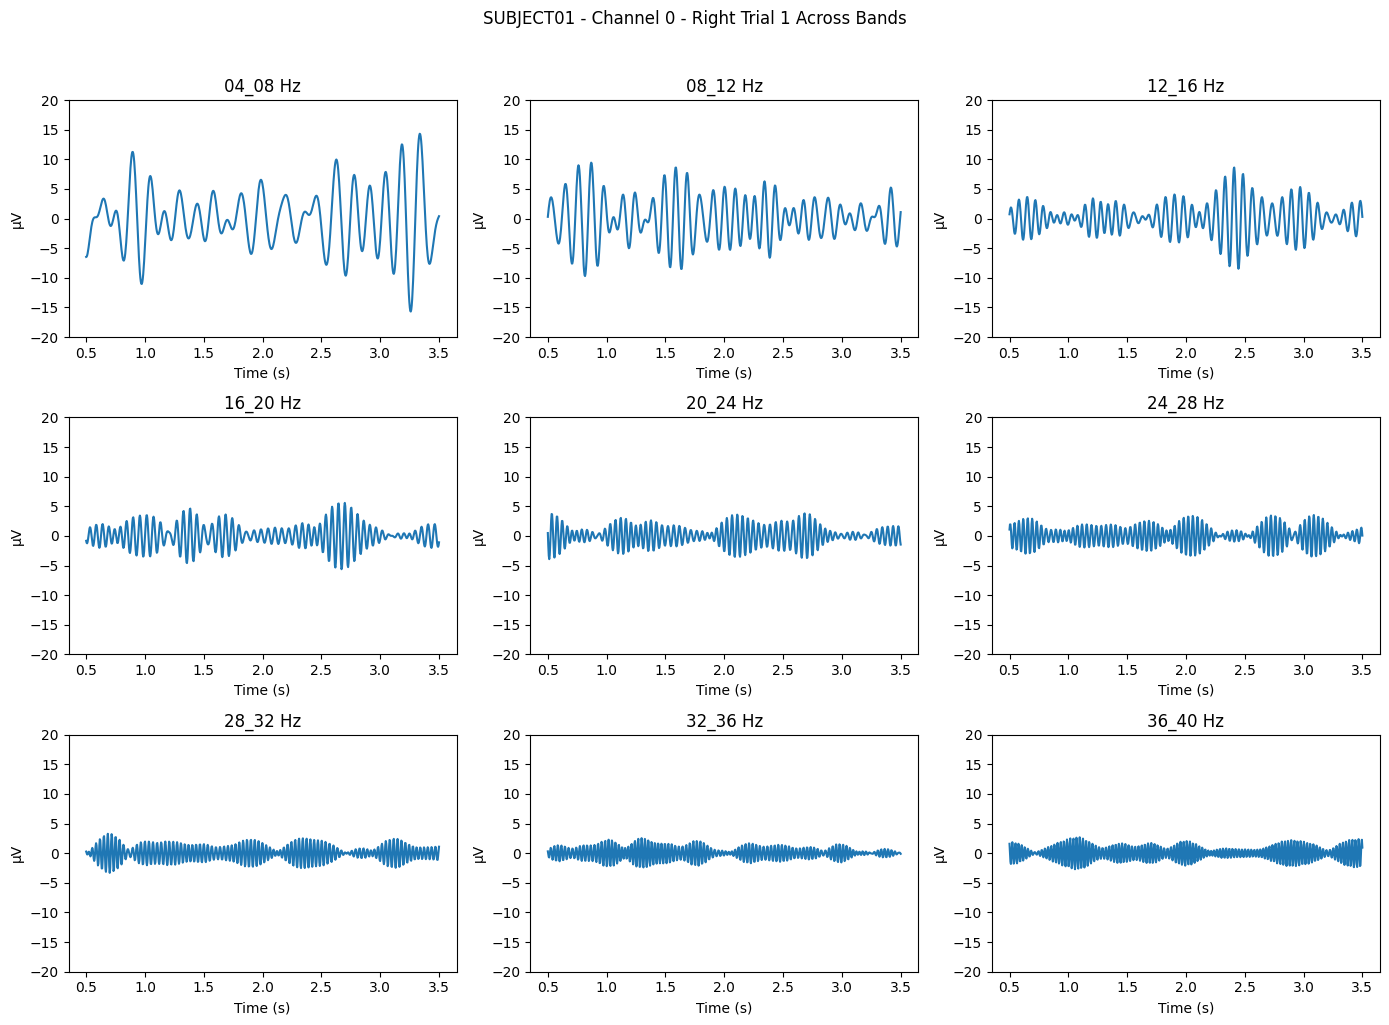

In [23]:
import matplotlib.pyplot as plt

# Trial timing details
fs = 250
start_time = 0.5  # seconds
end_time = 3.5
start = int(start_time * fs)
end = int(end_time * fs)
time_axis = np.linspace(start_time, end_time, end - start)

# Get left hand trial position (first trial)
trial_pos = subjectData[subject]['epos'][subjectData[subject]['etyp'] == 769][0]  # class 770 = right hand

channel = 0  # EEG channel

# Plot all bands
plt.figure(figsize=(14, 10))
for i, (band, data) in enumerate(band_filtered_subject01.items()):
    signal = data[channel, trial_pos + start : trial_pos + end]
    plt.subplot(3, 3, i + 1)
    plt.plot(time_axis, signal)
    plt.title(f'{band} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('µV')
    plt.ylim([-20, 20])
    plt.tight_layout()

plt.suptitle(f'{subject.upper()} - Channel {channel} - Right Trial 1 Across Bands', y=1.02)
plt.tight_layout()
plt.show()